<a href="https://colab.research.google.com/github/Navam04/CSC490-Navam---Laurence/blob/main/CSC490_Navam_Laurence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

import os
import shutil
import random
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from ultralytics import YOLO
import kagglehub

# Optional: save outputs to Drive
USE_DRIVE = False  # set True if you want to mount Google Drive and save results there

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive")

# Core paths and settings
DATA_ROOT = "/content/dataset"
IMG_SIZE = 640

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
def download_and_prepare_afo(data_root=DATA_ROOT):
    # 1. Download raw dataset via kagglehub
    path = kagglehub.dataset_download(
        "jangsienicajzkowy/afo-aerial-dataset-of-floating-objects"
    )
    print("Path to raw dataset:", path)

    labels_dir = os.path.join(path, "PART_1", "PART_1", "6categories")
    splits_dir = os.path.join(path, "PART_1", "PART_1")
    # Fix: Adjust images_dirs for correct dataset structure
    images_dirs = [
        os.path.join(path, "PART_1", "PART_1", "images"), # PART_1 has nested PART_1
        os.path.join(path, "PART_2", "images"),          # PART_2 likely does not
        os.path.join(path, "PART_3", "images"),          # PART_3 likely does not
    ]

    # 2. Create YOLO directory structure
    images_out = {
        "train": os.path.join(data_root, "images", "train"),
        "val":   os.path.join(data_root, "images", "val"),
        "test":  os.path.join(data_root, "images", "test"),
    }
    labels_out = {
        "train": os.path.join(data_root, "labels", "train"),
        "val":   os.path.join(data_root, "labels", "val"),
        "test":  os.path.join(data_root, "labels", "test"),
    }

    for split in images_out:
        os.makedirs(images_out[split], exist_ok=True)
        os.makedirs(labels_out[split], exist_ok=True)

    def find_image(base_name):
        exts = [".jpg", ".jpeg", ".png"]
        # Remove any existing extension from base_name
        base_name_no_ext = os.path.splitext(base_name)[0]
        for d in images_dirs:
            for ext in exts:
                p = os.path.join(d, base_name_no_ext + ext)
                print(f"  Searching for image at: {p}") # Added debug print
                if os.path.exists(p):
                    return p
        return None

    mapping = {"train": "train", "validation": "val", "test": "test"}

    for split_src, split_dst in mapping.items():
        split_file = os.path.join(splits_dir, f"{split_src}.txt")
        if not os.path.exists(split_file):
            print(f"Missing split file: {split_file}, skipping")
            continue

        with open(split_file, "r") as f:
            base_names = [line.strip() for line in f if line.strip()]

        print(f"Preparing {split_src} ({len(base_names)} samples)...")

        for base in base_names:
            # FIX: Ensure label_src is constructed with .txt only, not .jpg.txt
            label_src = os.path.join(labels_dir, os.path.splitext(base)[0] + ".txt")
            img_src = find_image(base)

            if not os.path.exists(label_src):
                print("  Missing label:", label_src)
                continue
            if img_src is None:
                print("  No image for:", base)
                continue

            label_dst = os.path.join(labels_out[split_dst], os.path.basename(label_src))
            img_dst   = os.path.join(images_out[split_dst], os.path.basename(img_src))

            shutil.copy(label_src, label_dst)
            shutil.copy(img_src, img_dst)

    # 3. Write data.yaml with correct class names
    yaml_path = os.path.join(data_root, "data.yaml")
    with open(yaml_path, "w") as f:
        # Correct the newline characters to be \n instead of \\n
        f.write("path: /content/dataset\n")
        f.write("train: images/train\n")
        f.write("val: images/val\n")
        f.write("test: images/test\n")
        f.write("nc: 6\n")
        # Correct AFO class names in the standard order:
        # 0: human, 1: wind/sup-board, 2: boat, 3: buoy, 4: sailboat, 5: kayak
        f.write('names: ["human", "wind/sup-board", "boat", "buoy", "sailboat", "kayak"]\n')

    print("Wrote YAML:", yaml_path)

    def count_files(p):
        return len([x for x in os.listdir(p) if not x.startswith(".")])

    print("Train images:", count_files(images_out["train"]))
    print("Val images:  ", count_files(images_out["val"]))
    print("Test images: ", count_files(images_out["test"]))

    return yaml_path


DATA_YAML = download_and_prepare_afo()
print("DATA_YAML =", DATA_YAML)

Streaming output truncated to the last 5000 lines.
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_2/images/g_53.png
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_3/images/g_53.jpg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_3/images/g_53.jpeg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_3/images/g_53.png
  No image for: g_53.jpg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_1/PART_1/images/g_54.jpg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_1/PART_1/images/g_54.jpeg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_1/PART_1/images/g_54.png
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_2/images/g_54.jpg
  Searching for image at: /kaggle/input/afo-aerial-dataset-of-floating-objects/PART_2

In [ ]:
model = YOLO("yolo11s.pt")

results = model.train(
    data=DATA_YAML,
    epochs=150,
    batch=24,
    imgsz=IMG_SIZE,
    workers=2,
    patience=20,
    optimizer="AdamW",
    lr0=0.003,
    lrf=0.12,
    momentum=0.93,
    weight_decay=0.0005,
    cos_lr=True,
    amp=True,
    cache=True,
    project="runs-afo",
    name="yolo11s_afo_v1",
    pretrained=True,
)

# Validation on the val split
metrics = model.val(
    data=DATA_YAML,
    imgsz=IMG_SIZE,
    batch=8,
    plots=True,
    verbose=True,
)

print("\nValidation Results:")
try:
    for k, v in metrics.items():
        if isinstance(v, (int, float)):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")
except Exception:
    print("metrics object is not a dict in this ultralytics version; skipping detailed print.")

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.12, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.93, mosaic=1.0, multi_scale=False, name=yolo11s_afo_v13, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, p

In [ ]:
do_tune = True  # set False if you want to skip tuning

if do_tune:
    print("Starting hyperparameter tuning for YOLO11s...")
    model.tune(
        data=DATA_YAML,
        imgsz=IMG_SIZE,
        epochs= 20,       # tuning training epochs per trial
        iterations= 50,   # number of tuning trials
        optimizer="AdamW",
        cache=True,
        plots=False,
        val=False,       # tune with internal fitness, full val later
    )
    print("Tuning complete. Check 'runs/detect' or 'runs/detect/tune' folders for results.")
else:
    print("Skipping tuning.")


Starting hyperparameter tuning for YOLO11s...
Tuner: Initialized Tuner instance with 'tune_dir=/content/runs/detect/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0, 'close_mosaic': 10}
Saved /content/runs/detect/tune2/tune_scatter_plots.png
Saved /content/runs/detect/tune2/tune_fitness.png

Tuner: 1/5 iterations complete ✅ (164.72s)
Tuner: Results saved to /content/runs/detect/tune2
Tuner: Best fitness=0.00287 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.0177, 'metrics/recall

In [ ]:
def read_yolo_txt(txt_path, img_height, img_width):
    """
    Read YOLO-format labels and return list of weighted boxes:
    (weight, x1, y1, x2, y2) in pixel coordinates.
    Weights are class dependent.
    """
    boxes = []
    if not os.path.exists(txt_path):
        return boxes

    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls, xc, yc, w, h = map(float, parts)
            weight = 1.0
            if cls == 0:
                weight = 2.3
            if cls == 1:
                weight = 2.5
            if cls == 2:
                weight = 2.5
            if cls == 3:
                weight = 2.1
            if cls == 4:
                weight = 2.5
            # class 5 stays weight 1.0 by default, or adjust if you want

            # convert normalized coords to absolute pixels
            xc *= img_width
            yc *= img_height
            w  *= img_width
            h  *= img_height

            x1 = int(xc - w / 2)
            y1 = int(yc - h / 2)
            x2 = int(xc + w / 2)
            y2 = int(yc + h / 2)
            boxes.append((weight, x1, y1, x2, y2))

    return boxes


def generate_wake_mask(boxes, img_h, img_w):
    """
    Build a soft wake heatmap from weighted bounding boxes.

    - Sort boxes by size
    - Remove nested boxes
    - Draw an outer ellipse with value 1.0, then carve out a small inner ellipse (0.0)
    - Gaussian blur to get smooth wake patterns
    """
    mask = np.zeros((img_h, img_w), dtype=np.float32)

    # Sort boxes from largest to smallest
    boxes = sorted(boxes, key=lambda b: (b[4] - b[2]) * (b[3] - b[1]), reverse=True)

    # Filter out nested boxes
    filtered_boxes = []
    for (weight, x1, y1, x2, y2) in boxes:
        is_inside = False
        for (_, X1, Y1, X2, Y2) in filtered_boxes:
            if x1 >= X1 and y1 >= Y1 and x2 <= X2 and y2 <= Y2:
                is_inside = True
                break
        if not is_inside:
            filtered_boxes.append((weight, x1, y1, x2, y2))

    # Draw wake regions
    for (weight, x1, y1, x2, y2) in filtered_boxes:
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = (x2 - x1) * 2.0
        h = (y2 - y1) * 2.0

        # Outer wake region
        cv2.ellipse(
            mask,
            (int(cx), int(cy)),
            (int(w / 2), int(h / 2)),
            0,
            0,
            360,
            1.0,
            -1,
        )

        # Inner ellipse (object body) to hollow out the centre
        inner_scale = 0.3
        inner_w = w * inner_scale
        inner_h = h * inner_scale
        cv2.ellipse(
            mask,
            (int(cx), int(cy)),
            (int(inner_w / 2), int(inner_h / 2)),
            0,
            0,
            360,
            0.0,
            -1,
        )

    # Smooth the wake mask
    mask = cv2.GaussianBlur(mask, (9, 9), 0)
    mask = np.clip(mask, 0.0, 1.0)
    return mask


def generate_heatmaps_for_split(split="train", data_root=DATA_ROOT, img_size=IMG_SIZE):
    """
    Generate .npy wake heatmaps for a given split (train/val/test).
    We will primarily use this for the train split.
    """
    img_dir = os.path.join(data_root, "images", split)
    lbl_dir = os.path.join(data_root, "labels", split)
    hm_dir  = os.path.join(data_root, "heatmaps", split)
    os.makedirs(hm_dir, exist_ok=True)

    label_files = [f for f in os.listdir(lbl_dir) if f.endswith(".txt")]

    print(f"Generating heatmaps for split '{split}' ({len(label_files)} labels)...")

    for i, txt_name in enumerate(label_files, 1):
        base = os.path.splitext(txt_name)[0]
        # Try jpg and png for safety
        img_path = None
        for ext in [".jpg", ".jpeg", ".png"]:
            candidate = os.path.join(img_dir, base + ext)
            if os.path.exists(candidate):
                img_path = candidate
                break

        if img_path is None:
            print(f"  No image found for {base}, skipping.")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"  Could not read image {img_path}, skipping.")
            continue

        h, w = img.shape[:2]
        boxes = read_yolo_txt(os.path.join(lbl_dir, txt_name), h, w)
        if not boxes:
            # No objects, generate empty mask
            wake_mask = np.zeros((img_size, img_size), dtype=np.float32)
        else:
            wake_mask = generate_wake_mask(boxes, h, w)
            # Resize to IMG_SIZE x IMG_SIZE for UNet
            wake_mask = cv2.resize(
                wake_mask,
                (img_size, img_size),
                interpolation=cv2.INTER_LINEAR,
            )

        save_path = os.path.join(hm_dir, base + ".npy")
        np.save(save_path, wake_mask)

        if i % 200 == 0:
            print(f"  Processed {i} / {len(label_files)}")

    print("Done generating heatmaps for split:", split)


In [ ]:
generate_heatmaps_for_split("train")

Generating heatmaps for split 'train' (665 labels)...
  Processed 200 / 665
  Processed 400 / 665
  Processed 600 / 665
Done generating heatmaps for split: train


In [ ]:
class WakeDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=IMG_SIZE):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.files = sorted(
            [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        base = os.path.splitext(img_name)[0]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, base + ".npy")

        # Image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.float32) / 255.0
        img_t = torch.from_numpy(img).permute(2, 0, 1)  # CHW

        # Mask
        if os.path.exists(mask_path):
            mask = np.load(mask_path).astype(np.float32)
        else:
            mask = np.zeros((self.size, self.size), dtype=np.float32)

        if mask.shape != (self.size, self.size):
            mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_LINEAR)

        mask_t = torch.from_numpy(mask).unsqueeze(0)  # (1, H, W)

        return img_t, mask_t


class WakeDatasetVal(Dataset):
    def __init__(self, img_dir, size=IMG_SIZE):
        self.img_dir = img_dir
        self.size = size
        self.files = sorted(
            [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.float32) / 255.0
        img_t = torch.from_numpy(img).permute(2, 0, 1)

        return img_t, img_name


class SmallUNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Down
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        # Up
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),
            nn.ReLU(inplace=True),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        u1 = self.up1(d2)
        out = self.up2(u1)
        return out


In [ ]:
IMG_DIR_TRAIN = os.path.join(DATA_ROOT, "images", "train")
MASK_DIR_TRAIN = os.path.join(DATA_ROOT, "heatmaps", "train")

batch_size = 16
lr = 1e-4
epochs = 10

dataset_unet = WakeDataset(IMG_DIR_TRAIN, MASK_DIR_TRAIN, size=IMG_SIZE)
train_loader_unet = DataLoader(dataset_unet, batch_size=batch_size, shuffle=True, num_workers=2)

unet = SmallUNet().to(device)
optimizer_unet = torch.optim.Adam(unet.parameters(), lr=lr)
criterion_unet = nn.L1Loss()

print("UNet training on", len(dataset_unet), "images")

for epoch in range(1, epochs + 1):
    unet.train()
    running_loss = 0.0
    for imgs, masks in train_loader_unet:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer_unet.zero_grad()
        preds = unet(imgs)
        loss = criterion_unet(preds, masks)
        loss.backward()
        optimizer_unet.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader_unet.dataset)
    print(f"Epoch {epoch}/{epochs} - L1 loss: {epoch_loss:.4f}")

UNET_WEIGHTS = "/content/unet_wake.pth"
torch.save(unet.state_dict(), UNET_WEIGHTS)
print("Saved UNet weights to:", UNET_WEIGHTS)


UNet training on 665 images
Epoch 1/10 - L1 loss: 0.5539
Epoch 2/10 - L1 loss: 0.5475
Epoch 3/10 - L1 loss: 0.5344
Epoch 4/10 - L1 loss: 0.5002
Epoch 5/10 - L1 loss: 0.4313
Epoch 6/10 - L1 loss: 0.3398
Epoch 7/10 - L1 loss: 0.2584
Epoch 8/10 - L1 loss: 0.1986
Epoch 9/10 - L1 loss: 0.1566
Epoch 10/10 - L1 loss: 0.1286
Saved UNet weights to: /content/unet_wake.pth


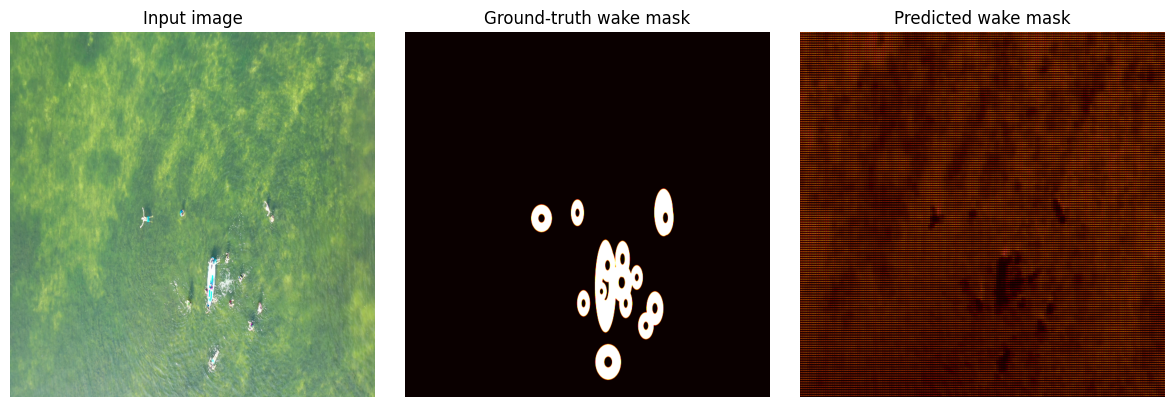

In [ ]:
unet.eval()

def show_unet_example(idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset_unet) - 1)

    img_t, mask_t = dataset_unet[idx]
    img = img_t.permute(1, 2, 0).numpy()
    gt_mask = mask_t.squeeze(0).numpy()

    with torch.no_grad():
        pred = unet(img_t.unsqueeze(0).to(device))
        pred = pred.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title("Input image")
    axs[1].imshow(gt_mask, cmap="hot")
    axs[1].set_title("Ground-truth wake mask")
    axs[2].imshow(pred, cmap="hot")
    axs[2].set_title("Predicted wake mask")
    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_unet_example()

In [ ]:
VAL_IMG_DIR = os.path.join(DATA_ROOT, "images", "val")
val_dataset = WakeDatasetVal(VAL_IMG_DIR, size=IMG_SIZE)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
def xyxy_to_yolo(x1, y1, x2, y2, img_w, img_h):
    """
    Convert XYXY box to YOLO-normalized (xc, yc, w, h).
    """
    w = x2 - x1
    h = y2 - y1
    xc = x1 + w / 2
    yc = y1 + h / 2
    return (
        xc / img_w,
        yc / img_h,
        w / img_w,
        h / img_h,
    )


def fuse_yolo_unet_on_image(
    img_tensor,
    img_name,
    yolo_model,
    unet_model,
    alpha=0.7,
    beta=0.3,
    img_size=IMG_SIZE,
):
    """
    - img_tensor: CHW float32 0-1, size img_size x img_size
    - returns fused boxes list: [x1, y1, x2, y2, final_conf, cls]
    """
    # Prepare image for YOLO predict (expects numpy HWC in RGB)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np_bgr = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

    # YOLO predictions
    yolo_results = yolo_model.predict(
        source=img_np_bgr,
        imgsz=img_size,
        conf=0.001,  # low threshold, we will re-weight with UNet
        verbose=False,
    )
    if len(yolo_results) == 0:
        return [], [], None

    res = yolo_results[0]
    boxes = res.boxes.xyxy.cpu().numpy()
    confs = res.boxes.conf.cpu().numpy()
    clses = res.boxes.cls.cpu().numpy()

    # UNet heatmap
    unet_model.eval()
    with torch.no_grad():
        inp = img_tensor.unsqueeze(0).to(device)
        heat = unet_model(inp).squeeze().cpu().numpy()  # H x W in [0,1]

    fused_boxes = []
    orig_boxes = []
    H, W = heat.shape

    for box, conf, cls in zip(boxes, confs, clses):
        x1, y1, x2, y2 = map(int, box)
        x1 = max(0, min(x1, W - 1))
        x2 = max(0, min(x2, W - 1))
        y1 = max(0, min(y1, H - 1))
        y2 = max(0, min(y2, H - 1))

        if x2 <= x1 or y2 <= y1:
            continue

        region = heat[y1:y2, x1:x2]
        if region.size == 0:
            continue

        unet_score = float(region.mean())
        final_conf = float(alpha * conf + beta * unet_score)

        fused_boxes.append([x1, y1, x2, y2, final_conf, int(cls)])
        orig_boxes.append([x1, y1, x2, y2, float(conf), int(cls)])

    return orig_boxes, fused_boxes, heat

In [ ]:
PRED_DIR_FUSED = "/content/pred_labels_fused"
os.makedirs(PRED_DIR_FUSED, exist_ok=True)

# Reload UNet from disk to be explicit
unet_fusion = SmallUNet().to(device)
unet_fusion.load_state_dict(torch.load(UNET_WEIGHTS, map_location=device))
unet_fusion.eval()

print("Running YOLO + UNet fusion on validation set...")

for img_t, img_name in val_loader:
    img_t = img_t.squeeze(0)  # CHW
    base = os.path.splitext(img_name[0])[0]

    orig_boxes, fused_boxes, heat = fuse_yolo_unet_on_image(
        img_t,
        img_name[0],
        model,          # your YOLO11s model
        unet_fusion,
        alpha=0.7,
        beta=0.3,
        img_size=IMG_SIZE,
    )

    if heat is None:
        continue

    # Write fused prediction file (class xc yc w h conf)
    txt_path = os.path.join(PRED_DIR_FUSED, base + ".txt")
    H, W = heat.shape

    with open(txt_path, "w") as f:
        for x1, y1, x2, y2, conf, cls in fused_boxes:
            xc, yc, bw, bh = xyxy_to_yolo(x1, y1, x2, y2, W, H)
            f.write(f"{cls} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f} {conf:.6f}\n")

print("Saved fused prediction labels to:", PRED_DIR_FUSED)

Running YOLO + UNet fusion on validation set...
Saved fused prediction labels to: /content/pred_labels_fused


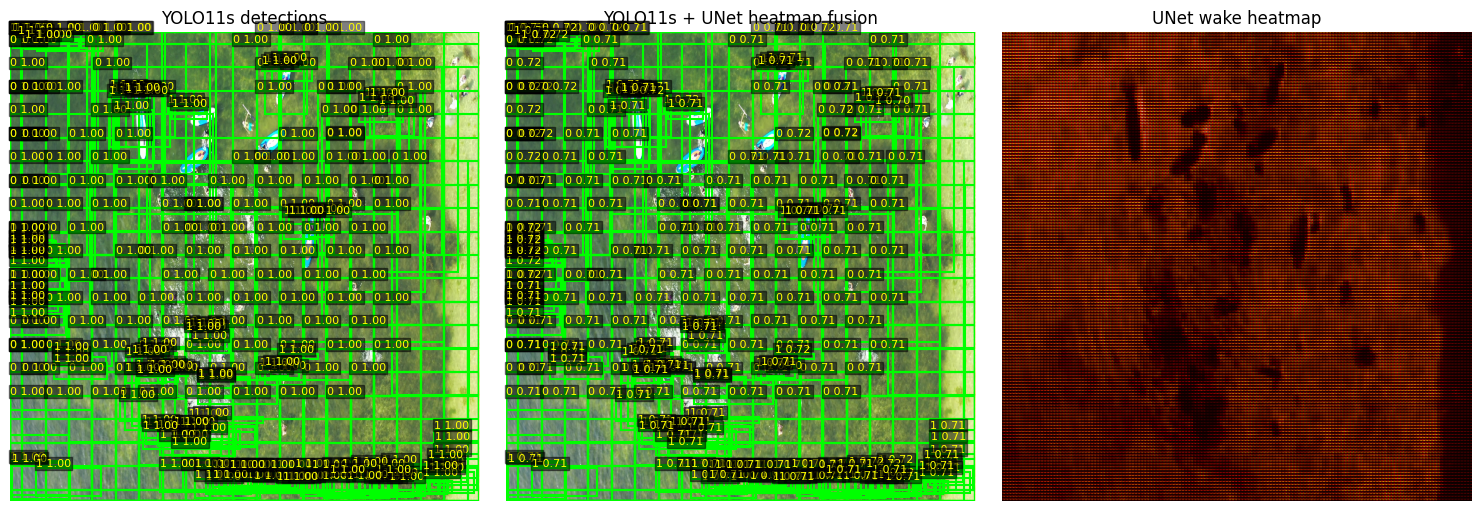

In [ ]:
import matplotlib.patches as patches

def plot_boxes(ax, img, boxes, title):
    ax.imshow(img)
    for x1, y1, x2, y2, conf, cls in boxes:
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=1.5,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            y1 - 2,
            f"{int(cls)} {conf:.2f}",
            color="yellow",
            fontsize=8,
            bbox=dict(facecolor="black", alpha=0.5, pad=1),
        )
    ax.set_title(title)
    ax.axis("off")


def show_fusion_example(idx=None):
    if idx is None:
        idx = random.randint(0, len(val_dataset) - 1)

    img_t, img_name = val_dataset[idx]
    img_np = img_t.permute(1, 2, 0).numpy()
    img_rgb = (img_np * 255).astype(np.uint8)

    orig_boxes, fused_boxes, heat = fuse_yolo_unet_on_image(
        img_t,
        img_name,
        model,
        unet_fusion,
        alpha=0.7,
        beta=0.3,
        img_size=IMG_SIZE,
    )

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_boxes(axs[0], img_rgb, orig_boxes, "YOLO11s detections")
    plot_boxes(axs[1], img_rgb, fused_boxes, "YOLO11s + UNet heatmap fusion")
    axs[2].imshow(heat, cmap="hot")
    axs[2].set_title("UNet wake heatmap")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


show_fusion_example()